<a href="https://colab.research.google.com/github/marfrlv/gpt-propaganda-detection/blob/main/document_level_metrics_all_conditions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# libraries
import pandas as pd
import os
from io import StringIO
import io
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import json
import warnings

In [ ]:
# Golden Dataset
golden_full_df_path = '/content/drive/MyDrive/thesis/semeval_2020_task_11_corpus/golden_labels_df_full.csv'
golden_full_df = pd.read_csv(golden_full_df_path)

# additional examples df
add_exm_df_path = '/content/drive/MyDrive/thesis/semeval_2020_task_11_corpus/additional_examples_for_chatgpt.csv'

# article IDs used in the experiment
article_ids_409_path = '/content/drive/MyDrive/thesis/article_IDs_exp_used.json'
with open(article_ids_409_path , 'r') as file:
  ids_409 = json.load(file)

# all articles folder path
all_art_fold_path = '/content/drive/MyDrive/thesis/all_articles'

In [ ]:
golden_ids = golden_full_df['id'].nunique()
print(f'There are {golden_ids} unique IDs in the Golden Dataset.')

There are 409 unique IDs in the Golden Dataset.


In [ ]:
def filter_df(df):
  df_filtered = df[(df["Text Span Presence"] != "False") & (df["Propaganda Technique"] != "irony") & (df["Propaganda Technique"] != "sarcasm") & (df["Propaganda Technique"] != "appeal_to_approach-avoidance")]
  return df_filtered

con1_df_path = '/content/drive/MyDrive/thesis/checked_dfs_with_no_prop_aug25/con1_final_df_aug24.csv'
con1_df = pd.read_csv(con1_df_path)
con1_df_filtered = filter_df(con1_df)

con2_df_path = '/content/drive/MyDrive/thesis/checked_dfs_with_no_prop_aug25/con2_final_df_aug24.csv'
con2_df = pd.read_csv(con2_df_path)
con2_df_filtered = filter_df(con2_df)

con3_df_path = '/content/drive/MyDrive/thesis/checked_dfs_with_no_prop_aug25/con3_final_df_aug24.csv'
con3_df = pd.read_csv(con3_df_path)
con3_df_filtered = filter_df(con3_df)

con4_df_path = '/content/drive/MyDrive/thesis/checked_dfs_with_no_prop_aug25/con4_final_df_aug24.csv'
con4_df = pd.read_csv(con4_df_path)
con4_df_filtered = filter_df(con4_df)


con5_df_path = '/content/drive/MyDrive/thesis/checked_dfs_with_no_prop_aug25/con5_final_df_aug24.csv'
con5_df = pd.read_csv(con5_df_path)
con5_df_filtered = filter_df(con5_df)

con6_df_path = '/content/drive/MyDrive/thesis/checked_dfs_with_no_prop_aug25/con6_final_df_aug24.csv'
con6_df = pd.read_csv(con6_df_path)
con6_df_filtered = filter_df(con6_df)

con7_df_path = '/content/drive/MyDrive/thesis/checked_dfs_with_no_prop_aug25/con7_final_df_aug24.csv'
con7_df = pd.read_csv(con7_df_path)
con7_df_filtered = filter_df(con7_df)

con8_df_path = '/content/drive/MyDrive/thesis/checked_dfs_with_no_prop_aug25/con8_final_df_aug24.csv'
con8_df = pd.read_csv(con8_df_path)
con8_df_filtered = filter_df(con8_df)

dfs_names = ["Condition 1 (Base 0ne-shot Temp0.7)", "Condition 2 (Base Few-shot Temp0.7)",
             "Condition 3 (CoT One-shot Temp0.7)", "Condition 4 (CoT Few-shot Temp0.7)",
             "Condition 5 (Base One-shot Temp 0)", "Condition 6 (Base Few-shot Temp 0)",
             "Condition 7 (CoT One-shot Temp 0)", "Condition 8 (CoT Few-shot Temp 0)"]
dfs = [con1_df, con2_df, con3_df, con4_df, con5_df, con6_df, con7_df, con8_df]
dfs_filtered = [con1_df_filtered, con2_df_filtered, con3_df_filtered, con4_df_filtered,
                con5_df_filtered, con6_df_filtered, con7_df_filtered, con8_df_filtered]

In [ ]:
def compare_and_calculate_accuracy(df1, df2, id_col_df1, id_col_df2, technique_col_df1, technique_col_df2):

    # convert Article ID columns to string
    df1 = df1.copy()
    df1[id_col_df1] = df1[id_col_df1].astype(str)

    df2 = df2.copy()
    df2[id_col_df2] = df2[id_col_df2].astype(str)

    # rename the columns for consistency
    df1.rename(columns={id_col_df1: 'Article ID', technique_col_df1: 'Propaganda Technique'}, inplace=True)
    df2.rename(columns={id_col_df2: 'Article ID', technique_col_df2: 'Propaganda Technique'}, inplace=True)

    # identify common and mismatching Article IDs
    ids_df1 = set(df1['Article ID'])
    ids_df2 = set(df2['Article ID'])

    common_article_ids = ids_df1.intersection(ids_df2)
    golden_mismatch_ids = list(ids_df1 - common_article_ids) # the ones that are present in the golden dataset but not present in the outputs
    model_mismatch_ids = list(ids_df2 - common_article_ids) # the ones that are present in the outputs but not on the golden dataset

    # print mismatching IDs
    #print(f"Golden Mismatch IDs length: {len(golden_mismatch_ids)}")
    #print(f"Golden Mismatch IDs: {golden_mismatch_ids[:5]}")
    #print(f"Model Mismatch IDs length: {len(model_mismatch_ids)}")
    #print(f"Model Mismatch IDs: {model_mismatch_ids[:5]}")

    # filter to include only common Article IDs
    df1_filtered = df1[df1['Article ID'].isin(common_article_ids)].copy()
    df2_filtered = df2[df2['Article ID'].isin(common_article_ids)].copy()

    # group by Article ID
    grouped_df1 = df1_filtered.groupby('Article ID')['Propaganda Technique'].apply(set).reset_index()
    grouped_df2 = df2_filtered.groupby('Article ID')['Propaganda Technique'].apply(list).reset_index()

    # merge the grouped DataFrames on Article ID
    merged_df = pd.merge(grouped_df1, grouped_df2, on='Article ID', suffixes=('_golden', '_model'))

    # calculate accuracy for each article
    def calculate_accuracy(row):
        L1 = row['Propaganda Technique_model']
        L2 = row['Propaganda Technique_golden']
        intersection = set(L1).intersection(L2)
        accuracy = len(intersection) / len(L2)
        return round(accuracy, 2)

    merged_df['accuracy'] = merged_df.apply(calculate_accuracy, axis=1)

    # calculate the mean accuracy score
    mean_accuracy = merged_df['accuracy'].mean()

    return merged_df, mean_accuracy

In [ ]:
golden_labels_df_filtered = golden_full_df

In [ ]:
for df_name, df_filtered in zip(dfs_names, dfs_filtered):
  print(df_name)
  merged_df, mean_accuracy = compare_and_calculate_accuracy(golden_labels_df_filtered, df_filtered, 'id', 'Article ID', 'technique', 'Propaganda Technique')
  print(f"Mean Accuracy Score: {mean_accuracy:.2f}")
  print('_______________________________________________')
  print()
  print()

Condition 1 (Base 0ne-shot Temp0.7)
Mean Accuracy Score: 0.65
_______________________________________________


Condition 2 (Base Few-shot Temp0.7)
Mean Accuracy Score: 0.63
_______________________________________________


Condition 3 (CoT One-shot Temp0.7)
Mean Accuracy Score: 0.64
_______________________________________________


Condition 4 (CoT Few-shot Temp0.7)
Mean Accuracy Score: 0.62
_______________________________________________


Condition 5 (Base One-shot Temp 0)
Mean Accuracy Score: 0.62
_______________________________________________


Condition 6 (Base Few-shot Temp 0)
Mean Accuracy Score: 0.62
_______________________________________________


Condition 7 (CoT One-shot Temp 0)
Mean Accuracy Score: 0.66
_______________________________________________


Condition 8 (CoT Few-shot Temp 0)
Mean Accuracy Score: 0.63
_______________________________________________




# Precision, Recall, F-1 score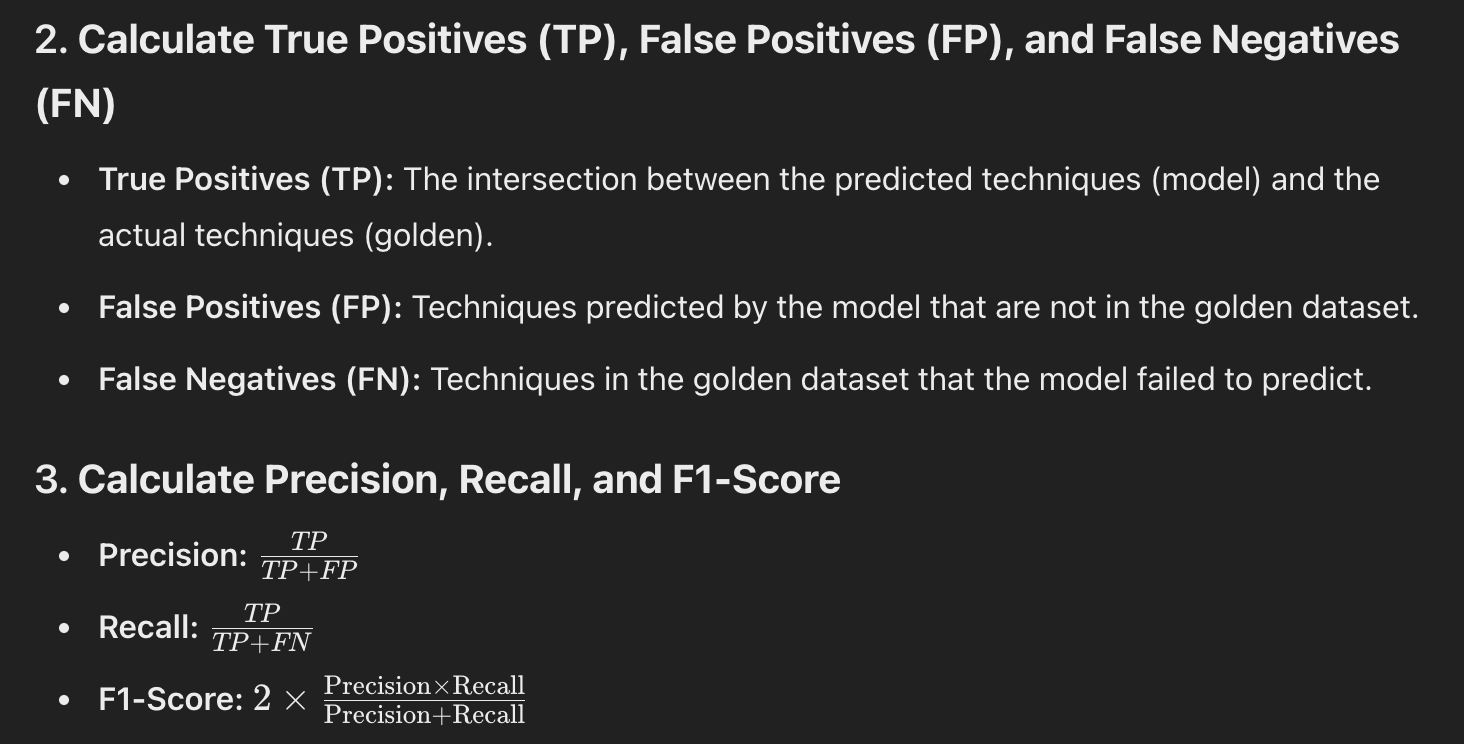

In [ ]:
def calculate_precision_recall_f1(merged_df):
  # initialize counters for TPs, FPs, and FNs
    TP = 0
    FP = 0
    FN = 0

    # iterate through each row to calculate TPs, FPs, and FNs
    for index, row in merged_df.iterrows():
        golden_set = row['Propaganda Technique_golden']  # already a set
        model_set = set(row['Propaganda Technique_model'])  # convert the list to a set

        # calculate TPs (intersection of sets)
        TP += len(golden_set.intersection(model_set))

        # Calculate FPs (model predictions not in golden set)
        FP += len(model_set - golden_set)

        # calculate FNs (golden set items not predicted by model)
        FN += len(golden_set - model_set)

    # calculate Precision, Recall, and F1-Score
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    # print the results
    print(f"Precision: {round(precision, 2)}")
    print(f"Recall: {round(recall, 2)}")
    print(f"F1-Score: {round(f1_score, 2)}")

    # return the results in a dictionary
    return {
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1_score
    }

In [ ]:
for df_name, df_filtered in zip(dfs_names, dfs_filtered):
  print(df_name)
  print('_______________________________________________')

  merged_df, accuracy = compare_and_calculate_accuracy(golden_labels_df_filtered, df_filtered, 'id', 'Article ID', 'technique', 'Propaganda Technique')

  calculate_precision_recall_f1(merged_df)
  print()
  print()
  print()

Condition 1 (Base 0ne-shot Temp0.7)
_______________________________________________
Precision: 0.47
Recall: 0.66
F1-Score: 0.55



Condition 2 (Base Few-shot Temp0.7)
_______________________________________________
Precision: 0.51
Recall: 0.63
F1-Score: 0.56



Condition 3 (CoT One-shot Temp0.7)
_______________________________________________
Precision: 0.46
Recall: 0.65
F1-Score: 0.54



Condition 4 (CoT Few-shot Temp0.7)
_______________________________________________
Precision: 0.5
Recall: 0.63
F1-Score: 0.56



Condition 5 (Base One-shot Temp 0)
_______________________________________________
Precision: 0.47
Recall: 0.63
F1-Score: 0.54



Condition 6 (Base Few-shot Temp 0)
_______________________________________________
Precision: 0.5
Recall: 0.63
F1-Score: 0.56



Condition 7 (CoT One-shot Temp 0)
_______________________________________________
Precision: 0.47
Recall: 0.67
F1-Score: 0.55



Condition 8 (CoT Few-shot Temp 0)
_______________________________________________
Precision